# Grover Adaptive Search Algorithm Tests 1

This Python notebook provides some practical tests and visualizations of the Grover Adaptive Search algorithm. All tests have been executed on the **OpenQASM Simulator** (https://sooluthomas.github.io/testTranslation/terra/executing_quantum_programs.html#executing-quantum-programs) offered by **Qiskit** (https://qiskit.org/), but any other backend (simulator or real quantum machine) can be used to run these tests.

In [23]:
from qiskit import *
from qiskit.visualization import plot_histogram

from random import getrandbits, randint, random

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse

import numpy as np

from binary_cost_function import *
from custom_gas import *
from num_base_converter import *

from functools import reduce

### Cost function:

First we define a binary cost function. Our chosen function for showing the preparator circuit will be:

$$
6 \cdot \left[\mathtt{X101}\right] + 3 \cdot \left[\mathtt{XXX0}\right] + 7 \cdot \left[\mathtt{X011}\right] - 2 \cdot \left[\mathtt{XXX1}\right] - 2 \cdot \left[\mathtt{01X1}\right],
$$

where $\mathtt{X}, \mathtt{0}$ and $\mathtt{1}$ denote free, 0 and 1 required bit values, respectively. That is, the cost function is:

$$
\mathcal{C}(x) = 6 \cdot x_2(1-x_3)x_4 + 3 \cdot (1-x_4) + 7 \cdot (1-x_2)x_3x_4 - 2 \cdot x_4 - 2 \cdot (1-x_1)x_2x_4.
$$

The clauses and values can be added, removed or changed as desired.

In [24]:
bcf_test = BinaryCostFunction(4)

clauses = [
    BinaryClause("X101"),
    BinaryClause("XXX0"),
    BinaryClause("X011"),
    BinaryClause("XXX1"),
    BinaryClause("01X1")
]

values = [6, 3, 7, -2, -2]

for clause, value in zip(clauses, values):
    bcf_test.add_clause(clause, value)
    
print(bcf_test)

6 * X101
3 * XXX0
7 * X011
-2 * XXX1
-2 * 01X1



### Circuit parameters:

  - `n`: Number of qubits for the first regiter, which is the number of bits of the binary cost function.
  - `m`: Number of qubits for the second register, for storing the evaluated binary cost function.
  - `bcf`: Binary cost function to optimize.

Recall that the $m$ will allow us to store integer values on the interval $\left[-2^{m-1}, 2^{m-1}-1\right]$. With our cost function, the worst cases would be when only the positive (or negative) value clauses are satisfied, giving us upper and lower bounds of its image: $\left[-4, 16\right]$. For this reason, we will choose

$$
m = \lceil \log_{2}(\max(\lvert -4\rvert\ , \lvert 16 \rvert +1)) \rceil + 1 = \lceil \log_{2}(17) \rceil + 1 \approx \lceil 4.087463 \rceil + 1 = 6
$$

to allow for values in the range $\left[-32, 31\right]$. We now add an extra qubit to account for the threshold, so that there is no overflow/underflow when extreme values of the threshold are set, giving out a final value of $m = 7$.

Any other binary cost function with adequate $n, m$ parameters can be tested.

In [25]:
bcf = bcf_test
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2

print("n = ", n, ", m = ", m, sep = "")
print("bcf: ")
print(bcf)

n = 4, m = 7
bcf: 
6 * X101
3 * XXX0
7 * X011
-2 * XXX1
-2 * 01X1



### Binary Clause: Circuit implementation and tests:

Example circuitExample circuit for one binary clause. We choose the first clause of the cost function: $\left[\mathtt{X010}\right]$, with value $6$, to showcase its circuit. for the binary clause $\left[\mathtt{X010}\right]$ with value 6.

In [26]:
clause_str = "X010"
clause_val = 6

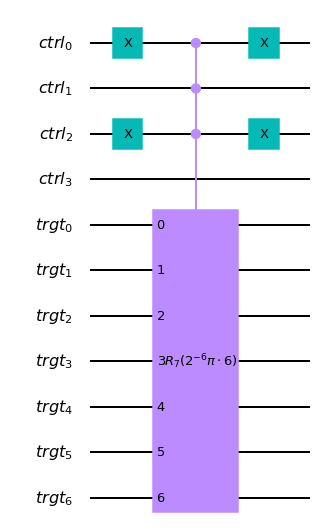

In [27]:
bc_circuit(m, BinaryClause(clause_str), 6).draw(output = "mpl")

We test the gate by codifying the string $\mathtt{0010}$ with $X$ gates on the `ctrl` register, which satisfies the clause. By adding other $X$ gates on other qubits of the `ctrl` register we can test other strings.

In [28]:
test_string = "0010"

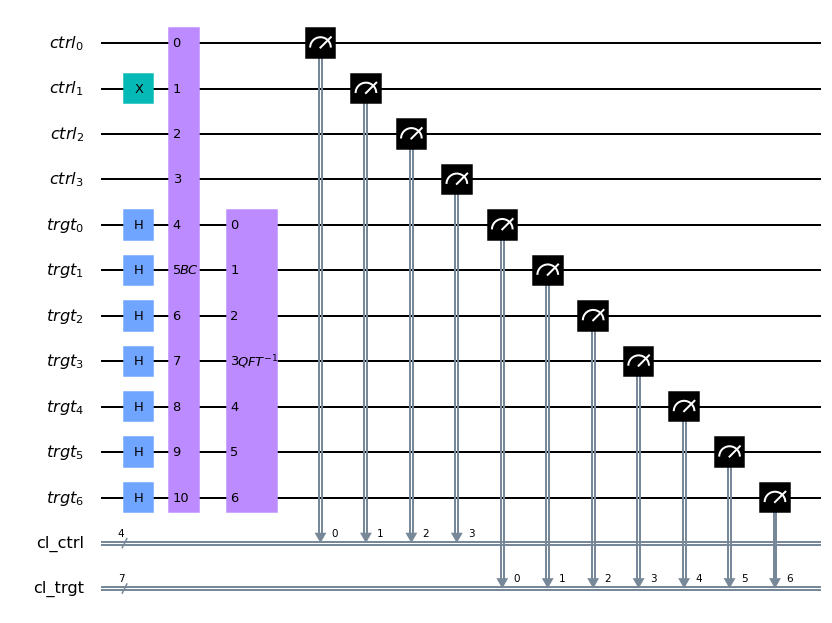

In [29]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

for pos, c in enumerate(test_string):
    if c == "1":
        qc.x(qr_ctrl[n - 1 - pos])

qc.h(qr_trgt[:])

qc.append(bc_circuit(m, BinaryClause("X010"), 6).to_gate(label = "$BC$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

After applying the binary clause gate and then the $\text{QFT}^{-1}$, the expected read string on the control register would be the evaluation string $\mathtt{0010}$, and on the target register, the value of the clause, $6$, codified in Two's complement, which is $\mathtt{0000110}$. Any other string can be tested to check that the clause gate works as intended.

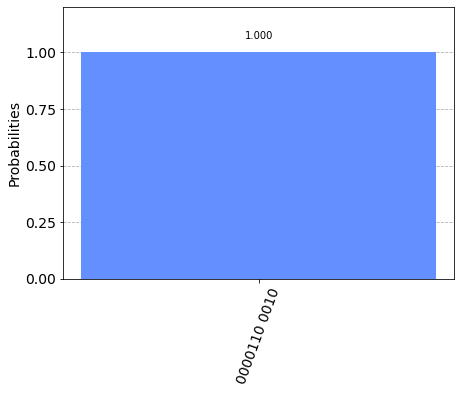

In [30]:
num_shots = 100000
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [31]:
ret_value, ret_str = tuple(list(counts.keys())[0].split(" "))
print("Expected string: {0:s}".format(test_string))
print("Returned string: {0:s}".format(ret_str))
print("Expected value: {0:d}".format(clause_val * BinaryClause(clause_str).evaluate(test_string)))
print("Returned value: {0:d}".format(bin_ca2_to_dec(ret_value)))

Expected string: 0010
Returned string: 0010
Expected value: 6
Returned value: 6


### Binary Cost Function: Circuit implementation and tests:

Circuit for the binary cost function, which is formed by clause gates corresponding to the binary clauses of the cost function in succession.

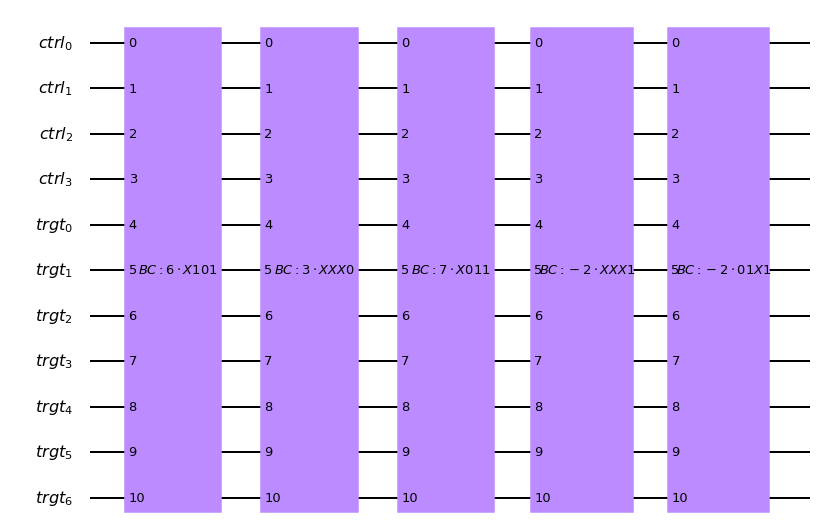

In [32]:
bcf_circuit(m, bcf).draw(output = "mpl")

We repeat the same test: Codify the string $\mathtt{0010}$ on the `ctrl` register and measure the result after the clause gates and the $\text{QFT}^{-1}$.

In [33]:
test_string = "0010"

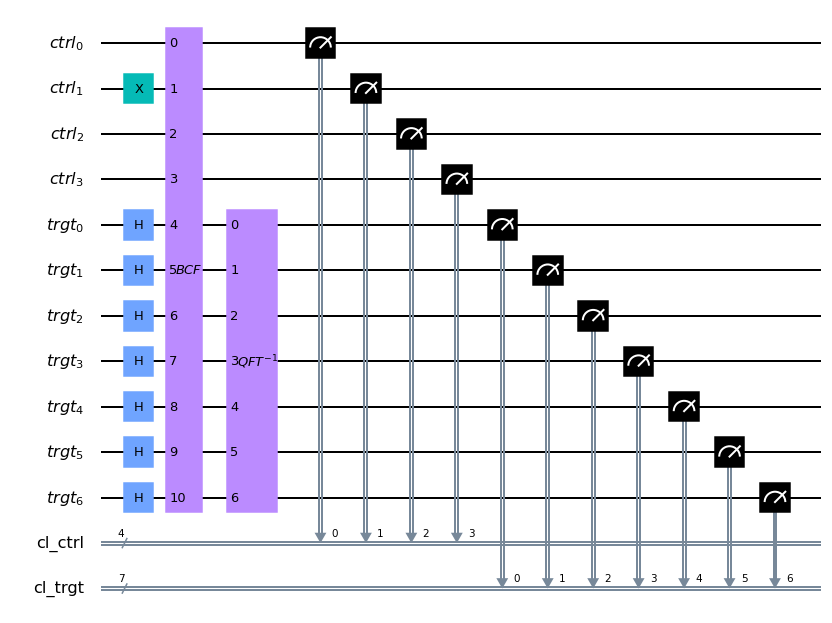

In [34]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

for pos, c in enumerate(test_string):
    if c == "1":
        qc.x(qr_ctrl[n - 1 - pos])
        
qc.h(qr_trgt[:])

qc.append(bcf_circuit(m, bcf).to_gate(label = "$BCF$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

This time, the expected read string on the `ctrl` register would be the same evaluation string $\mathtt{0010}$, and on the `trgt` register, the evaluation of the cost function on that string, $3$, codified in Two's complement, which is $\mathtt{0000011}$. Any other string can be tested to check that the circuit works.

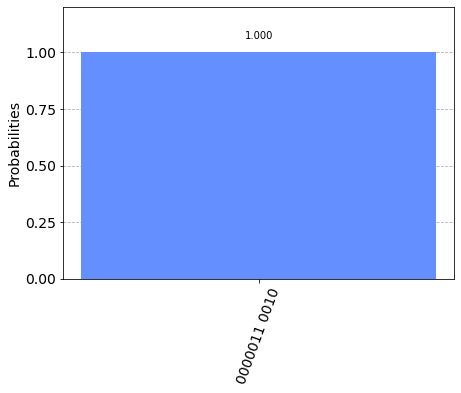

In [35]:
num_shots = 100000
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [36]:
ret_value, ret_str = tuple(list(counts.keys())[0].split(" "))
print("Expected string: {0:s}".format(test_string))
print("Returned string: {0:s}".format(ret_str))
print("Expected value: {0:d}".format(bcf.evaluate(test_string)))
print("Returned value: {0:d}".format(bin_ca2_to_dec(ret_value)))

Expected string: 0010
Returned string: 0010
Expected value: 3
Returned value: 3


### Operator $A$, Iterator $G$ and final circuit:

State preparator and function evaluator $A$.

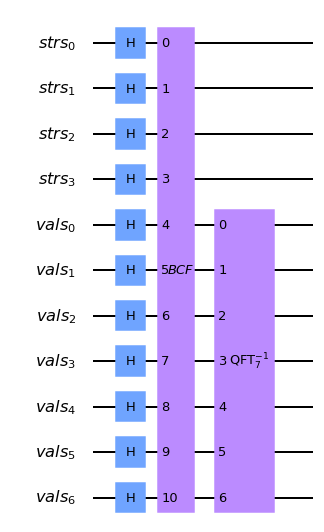

In [37]:
A_circuit(m, bcf).draw(output = "mpl")

Grover iterator $G = A D A^{-1} O$.

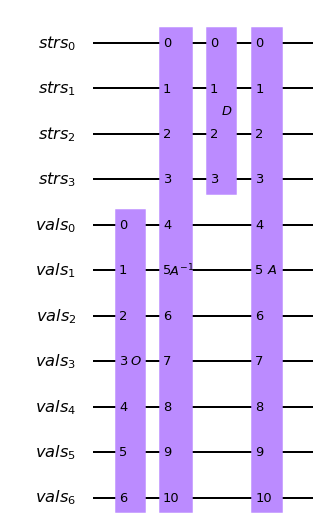

In [38]:
G_circuit(m, bcf).draw(output = "mpl")

### Grover Adaptive Search without Quantum Counting:

The strategy will be to choose a random string for an initial threshold. From there, until we get a better string, we apply Grover Search with $1$ $G$ application, $2, 3, ..., r_{max}$ where:

$$
r_{max} = \max_{t = 1}^{2^n} \left \lfloor \frac{\pi}{4} \frac{1}{\arcsin{\left(\sqrt{\frac{t}{2^{n}}}\right)}} \right \rfloor = \left \lfloor \frac{\pi}{4} \frac{1}{\arcsin{\left(\sqrt{\frac{1}{2^{n}}}\right)}} \right \rfloor.
$$

For $n = 4: r_{max} = 3$. If we get a better string, then we set the new optimal value as the new threshold and repeat from $1$ $G$ iteration to $r_{max}$. If we do not get a better string, then we stop the algorithm and return the best solution found so far. Here we do not use precalculated $r$ values and start again from $r = 0$ when a good result is found. The reason for this is that these techniques do not grant any advantages when the number of qubits $n$ is very low (by very low, we mean $n \leq 5$ or even $n \leq 6$ approximately).

In [39]:
r_max = math.floor(math.pi/(4*math.asin(2**(-n/2))))
print("r_max = {0:d}".format(r_max))

r_max = 3


In [40]:
def GAS_run(n, m, bcf, verbose = False):    
    #Best strings and values: First are chosen randomly
    best_strs = [dec_to_bin(getrandbits(n), n)]
    best_vals = [bcf.evaluate(best_strs[-1])]
    read_strs = [best_strs[-1]]
    read_vals = [best_vals[-1]]
    r_appls = []

    if verbose: print(("Initial conditions: x={0:s}, y={1:" + str(n) + "d}").format(best_strs[-1], best_vals[-1]))

    r = 0
    num_iters = 1
    while r <= r_max:
        r_appls.append(r)
        if verbose: print(("Iteration {0:" + str(n) + "d}: r={1:2d}").format(num_iters, r), end = "")

        #Create and run GAS quantum circuit
        # Threshold: Last best value
        qc = QuantumCircuit()
    
        qr_strs = QuantumRegister(n, "strs")
        qr_vals = QuantumRegister(m, "vals")
        qc.add_register(qr_strs)
        qc.add_register(qr_vals)
        
        cr_strs = ClassicalRegister(n, "cl_strs")
        cr_vals = ClassicalRegister(m, "cl_vals")
        qc.add_register(cr_strs)
        qc.add_register(cr_vals)
    
        qc.append(GAS_circuit(m, bcf, best_vals[-1], r).to_gate(), qr_strs[:] + qr_vals[:])
        qc.measure(qr_strs, cr_strs)
        qc.measure(qr_vals, cr_vals)
        
        job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 1)
        counts = job.result().get_counts()
        
        #Retrieve read_str and read_val
        results = list(counts.keys())[0].split(" ")
        read_str = results[1]
        read_val_bin = results[0]
        read_val = bin_ca2_to_dec(results[0])
        read_corr_val = read_val + best_vals[-1]
        read_strs.append(read_str)
        read_vals.append(read_val + best_vals[-1])

        if verbose: print((" x={0:s}, y={1:s} y_val={2:" + str(n) + "d}").format(read_str, read_val_bin, read_corr_val), end = "")

        #If read_corr_val is better (smaller) than best_vals[-1]: Update threshold and reset r to 1
        #If not: Do not update threshold, increase r by 1
        if read_corr_val < best_vals[-1]:
            best_strs.append(read_str)
            best_vals.append(read_corr_val)
            r = 0
            if verbose: print(" !! ", end = "")
        else:
            best_strs.append(best_strs[-1])
            best_vals.append(best_vals[-1])
            r += 1
            if verbose: print("    ", end = "")

        if verbose: print((" best_str={0:s}, best_val={1:" + str(n) + "d})").format(best_strs[-1], best_vals[-1]))
    
        #Update number of iterations
        num_iters += 1
    
    return best_strs, best_vals, read_strs, read_vals, r_appls

Execute the next cell to run the test.

In [41]:
best_strs, best_vals, read_strs, read_vals, r_appls = GAS_run(n, m, bcf, verbose = True)

Initial conditions: x=0010, y=   3
Iteration    1: r= 0 x=1100, y=0000000 y_val=   3     best_str=0010, best_val=   3)
Iteration    2: r= 1 x=0100, y=0000000 y_val=   3     best_str=0010, best_val=   3)
Iteration    3: r= 2 x=0000, y=0000000 y_val=   3     best_str=0010, best_val=   3)
Iteration    4: r= 3 x=0001, y=1111011 y_val=  -2 !!  best_str=0001, best_val=  -2)
Iteration    5: r= 0 x=0011, y=0000111 y_val=   5     best_str=0001, best_val=  -2)
Iteration    6: r= 1 x=0111, y=1111110 y_val=  -4 !!  best_str=0111, best_val=  -4)
Iteration    7: r= 0 x=0011, y=0001001 y_val=   5     best_str=0111, best_val=  -4)
Iteration    8: r= 1 x=1000, y=0000111 y_val=   3     best_str=0111, best_val=  -4)
Iteration    9: r= 2 x=0000, y=0000111 y_val=   3     best_str=0111, best_val=  -4)
Iteration   10: r= 3 x=1011, y=0001001 y_val=   5     best_str=0111, best_val=  -4)


Execute the next cell to visualize the results.

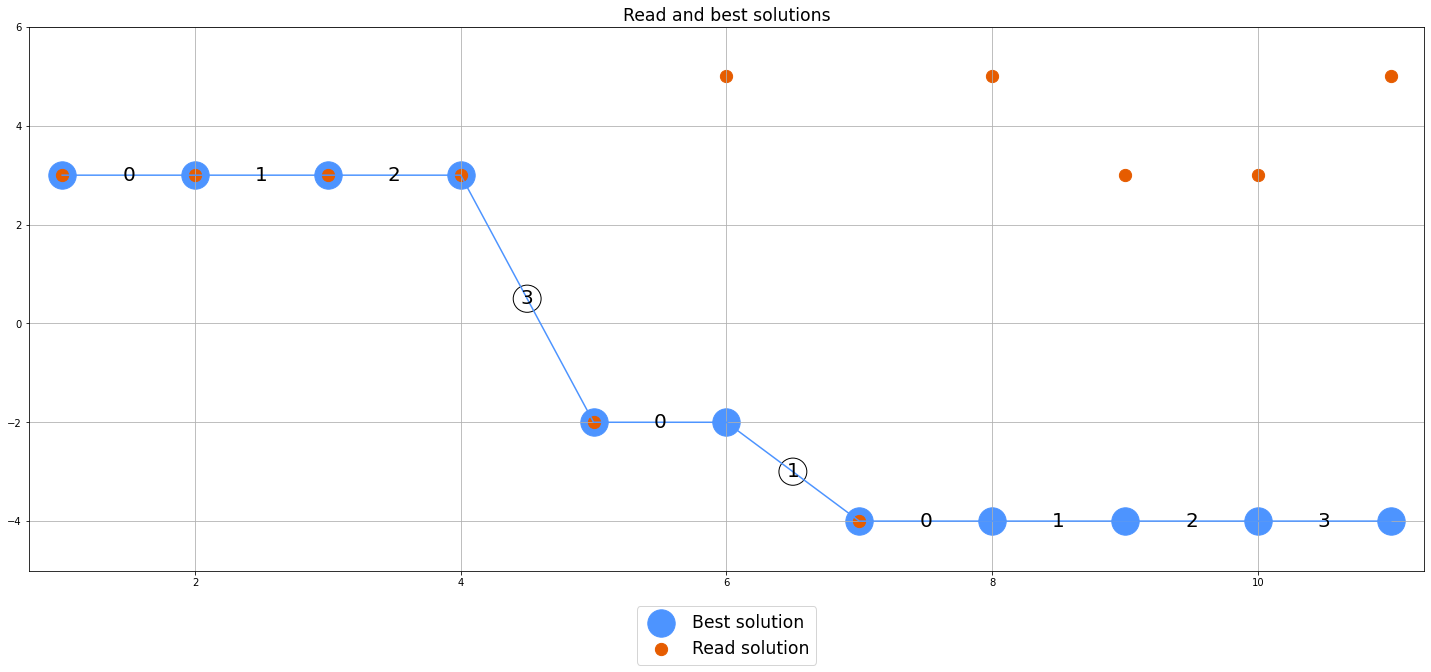

In [42]:
width, height = 25, 10
fig = plt.figure(figsize=(width, height))
ax = plt.subplot(1, 1, 1)
num_data = len(best_vals)
min_y, max_y = min(read_vals), max(read_vals)
x = np.arange(1, num_data+1)
ax.set_xlim(0.75, num_data + 0.25)
ax.set_ylim(min_y - 1, max_y + 1)
ax.plot(x, best_vals, color = "#4d94ff")
ax.scatter(x, best_vals, s = 750, color = "#4d94ff", label = "Best solution")
ax.scatter(x, read_vals, s = 150, color = "#e65c00", label = "Read solution")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize = "xx-large")
ax.set_title("Read and best solutions", fontsize = "xx-large")
ax.grid()
d = 0
w = width / (num_data - 0.5)
h = height / (max_y - min_y + 2)
r = 0.5
for i in range(num_data - 1):
    y1, y2 = best_vals[i], best_vals[i+1]
    if y1 != y2:
        ax.add_patch(Ellipse(
            (i + 1.5, ((y1 + y2) / 2)),
            width = r / w,
            height = r / h,
            color = "black",
            fill = False,
            linewidth = 1
        ))
    ax.text(
        i + 1.5,
        ((y1 + y2) / 2),
        str(r_appls[i]),
        verticalalignment = "center",
        horizontalalignment = "center",
        fontsize = 20
    )
plt.show()

Then we exhaustively evaluate the binary cost function to check if the returned result is correct. In some cases, the algorithm will succeed, but the returned string will be different. That can occur when more than one optimal solution exist, as the algorithm returns one of the optimal strings at random.

In [43]:
best_str, best_val = bcf.min_exhaustively()
print("Expected string: {0:s}".format(best_str))
print("Returned string: {0:s}".format(best_strs[-1]))
print("Expected value: {0:d}".format(best_val))
print("Returned value: {0:d}".format(best_vals[-1]))
print("Total G applications: {0:d}".format(sum(r_appls)))

Expected string: 0111
Returned string: 0111
Expected value: -4
Returned value: -4
Total G applications: 13


Here we run Grover Adaptive Search on the same problem a total of 100 times and check in how many the correct result is returned to estimate the chances of success. These chances depend on the chances of success of Grover Search, which increase as $n$ grows. In this case, as $n=4$ is a very low number, the algorithm might not return an optimal answer all the time.

To run the tests, execute the next cell. <span style="color:red">**Warning:**</span> The tests may take a few minutes to complete (approx. **25 mins**).

In [44]:
n_runs = 100

best_str, best_val = bcf.min_exhaustively()
n_success = 0
total_n_appl = 0
for n_run in range(n_runs):
    print("Run {0:6d}/{1:6d}... ".format(n_run, n_runs), end = "")
    best_strs, best_vals, read_strs, read_vals, r_appls = GAS_run(n, m, bcf)
    n_appl = len(best_strs)
    total_n_appl += n_appl
    
    if best_vals[-1] == best_val and bcf.evaluate(best_strs[-1]) == best_val:
        n_success += 1
        print("Success ", end = "")
    else:
        print("Failure ", end = "")
    print("with {0:d} G applications".format(n_appl))
        
print("\n -> Success rate: {0:2.2f}%".format(100*round(float(n_success)/n_runs, 4)))
print(" -> Average number of G applications: {0:f}".format(float(total_n_appl)/n_runs))

Run      0/   100... Success with 7 G applications
Run      1/   100... Success with 12 G applications
Run      2/   100... Success with 9 G applications
Run      3/   100... Success with 10 G applications
Run      4/   100... Success with 8 G applications
Run      5/   100... Success with 9 G applications
Run      6/   100... Success with 9 G applications
Run      7/   100... Success with 8 G applications
Run      8/   100... Success with 5 G applications
Run      9/   100... Success with 10 G applications
Run     10/   100... Success with 9 G applications
Run     11/   100... Success with 9 G applications
Run     12/   100... Success with 5 G applications
Run     13/   100... Success with 8 G applications
Run     14/   100... Success with 7 G applications
Run     15/   100... Success with 8 G applications
Run     16/   100... Success with 8 G applications
Run     17/   100... Success with 9 G applications
Run     18/   100... Success with 13 G applications
Run     19/   100... Succes